In [1]:
import torch
from torch import nn
from torchinfo import summary

from IPython.display import display as d

import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt

from einops import rearrange

import lightning as L

In [2]:
from src.data.components.dataset import CreditsHistoryDataset
from src.data.components.targets_indexes_reader import TargetsReader, IndexesReader
from src.data.components.data_reader import DataReader
from src.utils.sampler import SamplerFactory
from src.utils.metrics import GINI
from torchmetrics import MeanMetric

# Multitask research

In [3]:
emb_dim = 128

In [44]:
sample = torch.randint(0, 4, (5, ))

In [45]:
d(sample)

tensor([2, 0, 1, 3, 3])

In [46]:
a = nn.Embedding(num_embeddings=4, embedding_dim=8)

In [47]:
d(dict(a.named_parameters()))

{'weight': Parameter containing:
 tensor([[ 1.2962,  0.5405,  0.5765, -0.8487,  0.2105,  0.0374, -1.7631, -1.2126],
         [ 0.2306, -0.5026, -1.0136, -0.8195, -0.7585,  0.4862,  0.5229,  0.2072],
         [-0.2808, -0.1399,  0.6364,  0.4589,  0.8277,  1.0517, -0.7562,  1.4967],
         [ 0.4944, -0.2382,  0.6527, -0.6246, -0.8596, -1.7815,  0.0119,  1.2357]],
        requires_grad=True)}

In [49]:
d(a(sample))

tensor([[-0.2808, -0.1399,  0.6364,  0.4589,  0.8277,  1.0517, -0.7562,  1.4967],
        [ 1.2962,  0.5405,  0.5765, -0.8487,  0.2105,  0.0374, -1.7631, -1.2126],
        [ 0.2306, -0.5026, -1.0136, -0.8195, -0.7585,  0.4862,  0.5229,  0.2072],
        [ 0.4944, -0.2382,  0.6527, -0.6246, -0.8596, -1.7815,  0.0119,  1.2357],
        [ 0.4944, -0.2382,  0.6527, -0.6246, -0.8596, -1.7815,  0.0119,  1.2357]],
       grad_fn=<EmbeddingBackward0>)

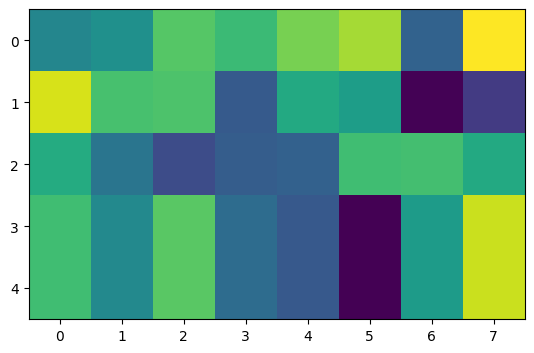

In [48]:
plt.imshow(a(sample).detach())

In [153]:
d(torch.concatenate([torch.stack(item).T for item in a]).unbind(dim=1))

(tensor([1, 2, 3, 1, 2, 3]), tensor([2, 3, 4, 2, 3, 4]))

In [6]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, dropout=0.1):
        super().__init__()

        self.position_wise_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )

        self.layer_norm = nn.LayerNorm(input_size, eps=1e-6)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.position_wise_layer(x)
        x = self.dropout(x)
        
        x += residual

        x = self.layer_norm(x)

        return x

In [31]:
class FooModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, max_seq_len: int = 50, dropout=0.1):
        super().__init__()

        self.position_wise_forward = PositionwiseFeedForward(
            input_size=emb_dim, 
            hidden_size=emb_dim * 2, 
            dropout=dropout
        )

        self.linear_layer = nn.Linear(emb_dim, 1)

        self.avg_pool = nn.AvgPool1d(kernel_size=max_seq_len)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self.position_wise_forward(inputs)

        x = self.linear_layer(x).squeeze()

        x = self.avg_pool(x)

        return x

In [7]:
some_batch = (torch.randn(size=(32, 50, emb_dim)), torch.randint(0, 2, (32, ), dtype=torch.float32))

In [32]:
some_model = FooModel(emb_dim, emb_dim * 2, 50)

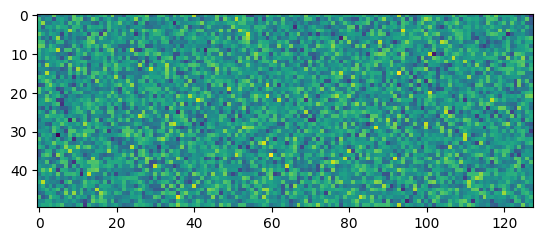

In [18]:
plt.imshow(some_batch[0][0])

In [33]:
d(some_model(some_batch[0]).size())

torch.Size([32, 1])

In [34]:
from torchmetrics.classification.auroc import BinaryAUROC

In [70]:
class GINI(BinaryAUROC):
    def __init__(self) -> None:
        super(GINI, self).__init__()
        
    def forward(self, logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        return (2. * super().forward(logits, labels) - 1.) * 100.
    
    # def compute(self) -> torch.Tensor:
    #     return super().compute()

In [71]:
a = GINI()

In [72]:
d(a(some_model(some_batch[0]), some_batch[1]))

tensor(43.7500)

In [119]:
d(some_model(some_batch[0]))

tensor([ 0.0903,  0.0469,  0.0347, -0.1100,  0.0162,  0.0895,  0.0320,  0.1441,
         0.0787,  0.0022,  0.0888, -0.0043,  0.1492, -0.0996,  0.0271,  0.0832,
        -0.0649,  0.0250,  0.0833, -0.0095,  0.1098,  0.1297,  0.0403,  0.0176,
        -0.0573, -0.0441, -0.1633,  0.0786, -0.0913,  0.0039, -0.0435, -0.0718],
       grad_fn=<MeanBackward1>)

In [86]:
d(a._buffers)

OrderedDict()

In [120]:
d((0.5749 * 2 - 1) * 100)

14.979999999999993

In [73]:
d(a.compute())

tensor(0.7188)

In [31]:
d(some_model.training_step(some_batch))

tensor(0.6924)
tensor(11.7409)
tensor(0.5587) 



/home/danil/projects/torch_template/.venv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


{'loss': tensor(0.6924, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)}

# Dataset

In [117]:
from src.data.components.collate import ModelInput, SingleForwardState, BaseCollator

In [118]:
def set_sampler(targets: dict, n_samples: int = 1000, replacement: bool = True):

    targets = np.asarray(list(targets.values()))
    
    sampler_factory = SamplerFactory(
        targets=targets, 
        n_samples=n_samples,
        replacement=replacement
    )
    return sampler_factory.balanced_random_sampler()

In [119]:
def initialize_data(features_path: str, data_path: str, indexes_path: str, targets_path: str, use_sampler: bool = True, batch_size: int = 32):
    features_dict = OmegaConf.load(features_path)

    data_reader = DataReader(data_path=data_path)
    data_reader.setup()

    indexes = IndexesReader(train_path=indexes_path).train_indexes

    targets = TargetsReader(targets_path).targets

    targets = {idx: targets.get(idx) for idx in indexes}

    dataset = CreditsHistoryDataset(
        data=data_reader, 
        targets=targets,
        indexes=indexes,
        features=features_dict
    )

    print(f"dataset sample: {dataset[0]}")

    train_sampler = set_sampler(
        targets=dataset.targets, 
        n_samples=10000,
        replacement=False
    ) if use_sampler else None

    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=BaseCollator(max_seq_len=50),
        sampler=train_sampler,
        drop_last=True
    ) 

    return dataloader, features_dict

In [120]:
test_dataloader, _ = initialize_data(
    "configs/data/features/features_credits_aggregated_v2.yaml",
    "./data/credits-history/serialized/serialized_first_part_v2",
    "./data/credits-history/indexes/ser_full_0_indexes/train_indexes.pickle",
    "./data/credits-history/targets/targets_dict.pickle",
    use_sampler=False,
    batch_size=1024
)

dataset sample: {'numerical': tensor([[ 1.9200,  1.0005,  0.8417,  0.5399,  7.2181,  0.0000],
        [ 2.7600,  2.0127,  0.9039, -0.4276,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 2.5200,  1.6636,  0.9957, -0.0927,  7.2181,  0.0000],
        [ 0.4800,  0.1688,  0.1680,  0.9858,  7.2181,  0.0000],
        [ 3.1200,  2.6531,  0.4693, -0.8830,  7.2181,  0.0000],
        [ 0.2400,  0.0925,  0.0923,  0.9957,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 1.2000,  0.4866,  0.4677,  0.8839,  7.2181,  0.0000],
        [ 2.2800,  1.3662,  0.9791,  0.2032,  7.2181,  0.0000],
        [ 2.6400,  1.8312,  0.9663, -0.2574,  7.2181,  0.0000]]), 'categorical': tensor([[ 8, 12,  2,  3,  0,  2,  4, 16,  2, 17,  1,  1,  1,  1,  3,  4,  4, 11,
          0],
        [ 8,  6,  2,  3,  0,  2,  4, 16,  2, 17,  1,  1,  1,  1,  3,  4,  4,  0,
         

In [121]:
dataloader, features_dict = initialize_data(
    "configs/data/features/features_credits_aggregated_v2.yaml",
    "./data/credits-history/serialized/serialized_first_part_v2",
    "./data/credits-history/indexes/ser_full_0_indexes/train_indexes.pickle",
    "./data/credits-history/targets/targets_dict.pickle"
)

dataset sample: {'numerical': tensor([[ 1.9200,  1.0005,  0.8417,  0.5399,  7.2181,  0.0000],
        [ 2.7600,  2.0127,  0.9039, -0.4276,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 2.5200,  1.6636,  0.9957, -0.0927,  7.2181,  0.0000],
        [ 0.4800,  0.1688,  0.1680,  0.9858,  7.2181,  0.0000],
        [ 3.1200,  2.6531,  0.4693, -0.8830,  7.2181,  0.0000],
        [ 0.2400,  0.0925,  0.0923,  0.9957,  7.2181,  0.0000],
        [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
        [ 1.2000,  0.4866,  0.4677,  0.8839,  7.2181,  0.0000],
        [ 2.2800,  1.3662,  0.9791,  0.2032,  7.2181,  0.0000],
        [ 2.6400,  1.8312,  0.9663, -0.2574,  7.2181,  0.0000]]), 'categorical': tensor([[ 8, 12,  2,  3,  0,  2,  4, 16,  2, 17,  1,  1,  1,  1,  3,  4,  4, 11,
          0],
        [ 8,  6,  2,  3,  0,  2,  4, 16,  2, 17,  1,  1,  1,  1,  3,  4,  4,  0,
         

In [122]:
d(next(iter(dataloader)))

ModelBatch(numerical=tensor([[[ 1.1200,  0.5315,  0.5068,  0.8620,  7.2181,  0.2000],
         [ 2.4000,  1.5090,  0.9981,  0.0618,  7.2181,  0.0000],
         [ 2.8800,  2.2093,  0.8030, -0.5960,  7.2181,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 2.0400,  1.1128,  0.8969,  0.4422,  7.2181,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 2.2800,  1.3662,  0.9791,  0.2032,  7.2181,  0.0000],
         [ 0.1200,  0.0587,  0.0586,  0.9983,  7.2181,  0.0000],
         [ 2.8800,  2.2093,  0.8030, 

# Model

## Get sample check 

In [123]:
def get_sample():
    batch = next(iter(dataloader))

    x = ModelInput(
        numerical=batch.numerical,
        categorical=batch.categorical,
        lengths=batch.lengths
    )

    labels = batch.targets

    return x, labels

In [124]:
sample = get_sample()

In [125]:
d(sample[0].numerical.size())

torch.Size([32, 50, 6])

In [126]:
d(rearrange(sample[0].numerical, "N L H -> N H L"))

tensor([[[ 0.1600,  1.9200,  1.5600,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0800,  1.0005,  0.7129,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0800,  0.8417,  0.6540,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.9968,  0.5399,  0.7565,  ...,  0.0000,  0.0000,  0.0000],
         [ 7.2181,  7.2181,  7.2181,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.2000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1200,  2.2800,  2.2800,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0587,  1.3662,  1.3662,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0586,  0.9791,  0.9791,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.9983,  0.2032,  0.2032,  ...,  0.0000,  0.0000,  0.0000],
         [ 7.2181,  7.2181,  7.2181,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.2000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 2.2800,  1.7200,  0.1600,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.3662,  0.8417,  0.0800,  ...,  0.0000,  0.0000,  0.0000],
  

## Model layers check

In [25]:
class EmbeddingLayer(nn.Module):
    def __init__(
            self,
            categorical_features: dict,
            embedding_dim: int = 32,
            div_emb_dim: int = 4
        ) -> None:
        super(EmbeddingLayer, self).__init__()

        self.categorical_features = categorical_features

        self.embeddings = nn.ModuleList()

        for num_embs in self.categorical_features.values():
            embedding = nn.Embedding(
                num_embeddings=num_embs, 
                embedding_dim=embedding_dim // div_emb_dim
            )

            nn.init.xavier_normal_(embedding.weight, gain=nn.init.calculate_gain('relu'))

            self.embeddings.append(embedding)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = torch.concatenate(
            [embedding(x[..., idx]) for idx, embedding in enumerate(self.embeddings)], dim=-1
        ) # size = (batch_size, len(cat_features), embedding_dim)
        
        return x

    
class EncoderLayer(nn.Module):
    def __init__(
            self,
            numerical_features: list,
            categorical_features: dict,
            embedding_dim: int = 16,
            dropout_inputs: float = 0.5,
            non_linear: bool = False,
            num_batch_norm: bool = True,
            div_emb_dim: int = 4
        ) -> None:
        super(EncoderLayer, self).__init__()

        self.dropout = nn.Dropout(p=dropout_inputs)

        self.numerical_features = numerical_features
        self.categorical_features = categorical_features

        self.embeddings = EmbeddingLayer(
            categorical_features=categorical_features,
            embedding_dim=embedding_dim,
            div_emb_dim=div_emb_dim
        )

        if non_linear:
            self.out_linear_block = nn.Sequential(
                nn.Linear(
                    (embedding_dim // div_emb_dim) * len(self.categorical_features)  + len(self.numerical_features), 
                    embedding_dim
                ),
                nn.ReLU(),

                nn.Linear(embedding_dim, embedding_dim),
                nn.ReLU()
            )
        else:
            self.out_linear_block = nn.Linear(
                (embedding_dim // div_emb_dim) * len(self.categorical_features) + len(self.numerical_features), 
                embedding_dim
            )

        if num_batch_norm:
            self.num_bn = nn.BatchNorm1d(len(self.numerical_features))
        else: 
            self.num_bn = None

    def forward(self, inputs: ModelInput) -> SingleForwardState:

        embeddings = self.embeddings(inputs.categorical)
        
        if self.num_bn is None:
            x_num = inputs.numerical
        else:
            x_num = rearrange(inputs.numerical, "N L H -> N H L")

            x_num = self.num_bn(x_num)

            x_num = rearrange(x_num, "N H L -> N L H")
            
        x = torch.concatenate((x_num, embeddings), dim=-1)

        x = self.dropout(x)
        x = self.out_linear_block(x)

        return SingleForwardState(
            sequences=x, 
            lengths=inputs.lengths
        )

In [26]:
class SimpleAttention1d(nn.Module):
    def __init__(self, features_dim: int):
        super(SimpleAttention1d, self).__init__()

        self.features_dim = features_dim

        self.linear = nn.Linear(self.features_dim, self.features_dim)
        self.bn_layer = nn.BatchNorm1d(self.features_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: SingleForwardState) -> SingleForwardState:
        att_x = self.linear(x.sequences)

        att_x = rearrange(att_x, "N L H -> N H L")

        att_x = self.softmax(self.bn_layer(att_x))

        att_x = rearrange(att_x, "N H L -> N L H")
        
        att_sequences = x.sequences * att_x

        return SingleForwardState(
            sequences=att_sequences,
            lengths=x.lengths
        )

In [27]:
class GRUSeqToSeq(nn.Module):
    def __init__(
            self,
            hidden_size: int, 
            num_layers_gru: int = 1,
            bidirectional: bool = False,
            dropout_gru: float = 0.0
    ) -> None:
        super(GRUSeqToSeq, self).__init__()

        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers_gru,
            bidirectional=bidirectional,
            dropout=dropout_gru
        )

    def forward(self, x: SingleForwardState) -> SingleForwardState:

        packed_sequences = torch.nn.utils.rnn.pack_padded_sequence(
            input=x.sequences, 
            lengths=x.lengths, 
            batch_first=True, 
            enforce_sorted=False
        )

        state, _ = self.gru(packed_sequences)

        padded_state, _ = torch.nn.utils.rnn.pad_packed_sequence(state, batch_first=True)

        # unpacked_sequences = torch.nn.utils.rnn.unpack_sequence(packed_sequences=packed_sequences)

        return SingleForwardState(
            sequences=padded_state,
            lengths=x.lengths
        )

In [28]:
x_enc_ = EncoderLayer(
    numerical_features=features_dict["numerical"],
    categorical_features=features_dict["categorical"],
    embedding_dim=32,
    dropout_inputs=0.1
)

In [29]:
x_enc = x_enc_(sample[0])

In [30]:
d(x_enc)

SingleForwardState(sequences=tensor([[[ 0.5259, -0.2437, -0.5757,  ..., -0.5438,  0.3662, -0.4735],
         [ 0.5180, -0.1474, -0.3920,  ..., -0.4886, -0.3882,  0.2314],
         [ 0.1812, -0.4041, -0.5693,  ..., -0.6219, -0.0128, -0.0935],
         ...,
         [-0.3381, -0.0586, -0.3365,  ..., -0.2523,  0.3794, -0.1328],
         [-0.4922, -0.0100, -0.2548,  ..., -0.3652,  0.4200, -0.1312],
         [-0.3738, -0.1144, -0.1217,  ..., -0.2849,  0.1392, -0.2825]],

        [[ 0.1971, -0.5017, -0.4344,  ..., -0.6294, -0.2103,  0.4232],
         [ 0.5734, -0.4943, -0.8932,  ..., -0.7433, -0.1422, -0.4528],
         [ 0.2724, -0.7024, -0.6399,  ..., -0.4498,  0.1105,  0.0734],
         ...,
         [-0.3234, -0.1822, -0.2758,  ..., -0.3236,  0.2283, -0.2851],
         [-0.3222, -0.0063, -0.3347,  ..., -0.0862,  0.3613, -0.0938],
         [-0.3000,  0.1334, -0.2906,  ..., -0.0770,  0.2851, -0.1773]],

        [[ 0.1207, -0.1098, -0.5983,  ..., -1.0455, -0.3807, -0.4127],
         [ 0.485

In [31]:
d(x_enc.sequences.size())

torch.Size([32, 50, 32])

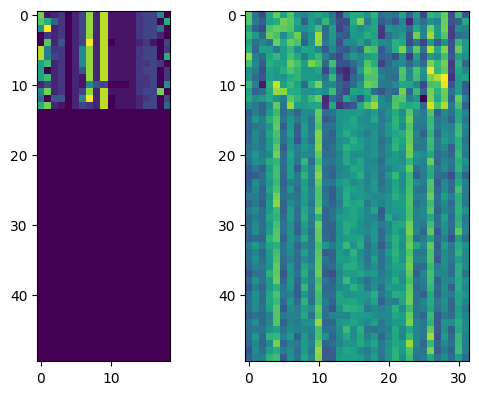

In [32]:
figure = plt.figure(figsize=(12, 10))

ax = figure.add_subplot(2, 2, 1)
ax.imshow(sample[0].categorical[0])

ax = figure.add_subplot(2, 1, 1)
ax.imshow(x_enc.sequences[0].detach())

In [33]:
x_att = SimpleAttention1d(features_dim=32)(x_enc)

In [34]:
d(x_att.sequences.size())

torch.Size([32, 50, 32])

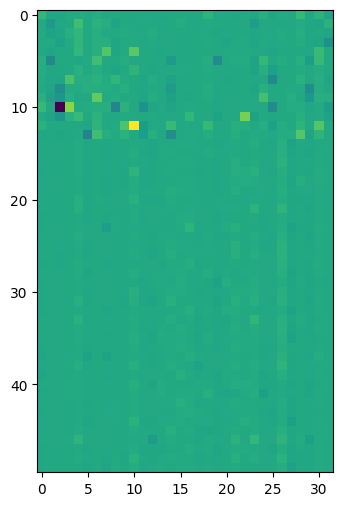

In [35]:
figure = plt.figure(figsize=(6, 6))

ax = figure.add_subplot()
ax.imshow(x_att.sequences[0].detach())

In [36]:
x_gru_ = GRUSeqToSeq(
    hidden_size=32,
    num_layers_gru=1
)

In [37]:
x_gru = x_gru_(x_att)

In [38]:
d(x_gru.sequences.size())

torch.Size([32, 24, 32])

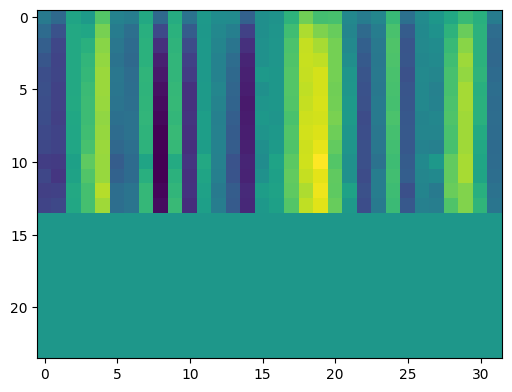

In [39]:
figure = plt.figure(figsize=(6, 6))

ax = figure.add_subplot()
ax.imshow(x_gru.sequences[0].detach())

In [40]:
from src.models.components.pooling.agg_pooling import ConvPooling

In [41]:
x_pooled_ = ConvPooling(pooling_type="avg", dim=1)

In [42]:
d(x_pooled_)

ConvPooling(
  (pooling_layer): AvgPooling()
  (agg_layer): Identity()
)

In [43]:
x_pooled = x_pooled_(x_gru)

In [44]:
d(x_pooled.representations.size())

torch.Size([32, 32])

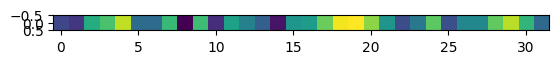

In [45]:
plt.imshow(x_pooled.representations[0].detach().unsqueeze(dim=0))

In [46]:
from src.data.components.collate import ModelOutput
from typing import List, Tuple

In [47]:
ACTIVATION_TYPE_MAPPING = {
    "tanh": nn.Tanh,
    "gelu": nn.GELU,
    "relu": nn.ReLU,
    "none": nn.Identity
}

def init_linear_block_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(layer.bias)

class LinearBlock(nn.Module):
    def __init__(
            self, 
            in_features: int, 
            out_features: int = 1, 
            num_layers: int = 3, 
            dropout_rate: float = 0.0, 
            activation_type: str = "tanh",
            use_batch_norm: bool = False,
            bias: bool = True
        ) -> None:
        super(LinearBlock, self).__init__()

        self.in_features = in_features

        self.dropout = nn.Dropout(p=dropout_rate)

        if activation_type is None:
            self.act = ACTIVATION_TYPE_MAPPING["tanh"]
        elif activation_type in ACTIVATION_TYPE_MAPPING.keys():
            self.act = ACTIVATION_TYPE_MAPPING[activation_type]
        else: 
            NotImplementedError(f"activation_type must be in <{list(ACTIVATION_TYPE_MAPPING.keys())}>")

        if use_batch_norm:
            self.layer_norm = nn.BatchNorm1d
        else:
            self.layer_norm = nn.LayerNorm

        self.linear_block = nn.Sequential(
            *[
                nn.Sequential(
                    *[
                        nn.Linear(in_features // (2 ** i), in_features // (2 ** (i + 1)), bias),
                        self.layer_norm(in_features // (2 ** (i + 1))),
                        self.act()
                    ]
                ) for i in range(num_layers)
            ]
        )
        

        self.out_block = nn.Linear(
            in_features=in_features // (2 ** num_layers), out_features=out_features
        )

        self.cls_layers = nn.Sequential(
            self.dropout,
            self.linear_block,
            self.out_block,
            self.act()
        )

        # weights init
        self.cls_layers.apply(init_linear_block_weights)


    def forward(self, x: ModelOutput) -> ModelOutput:
        logits = self.cls_layers(x.representations)

        return ModelOutput(
            representations=x.representations,
            logits=logits
        )


class MultiTaskLinearBlock(nn.Module):
    def __init__(
            self,
            heads: List[LinearBlock]
    ) -> None: 
        super(MultiTaskLinearBlock, self).__init__()

        self.heads = nn.ModuleList(heads)

    def forward(self, x: ModelOutput) -> ModelOutput:
        multi_state = [
            head(x).logits for head in self.heads
        ]

        logits = torch.concat(multi_state, dim=1) # size(batch_size, num_outputs)
        
        return ModelOutput(
            representations=x.representations,
            logits=logits
        )

In [48]:
x_out = MultiTaskLinearBlock(
    heads=[
        LinearBlock(32, 1, 2)
    ]
)(x_pooled)

In [49]:
d(x_out)

ModelOutput(representations=tensor([[-0.0807, -0.0925,  0.0185,  ...,  0.0862,  0.0276, -0.0489],
        [-0.0164, -0.0240,  0.0047,  ...,  0.0191,  0.0072, -0.0139],
        [-0.0550, -0.0686,  0.0153,  ...,  0.0614,  0.0193, -0.0378],
        ...,
        [-0.0029, -0.0036,  0.0004,  ...,  0.0021,  0.0021, -0.0017],
        [-0.1101, -0.1254,  0.0267,  ...,  0.1202,  0.0347, -0.0692],
        [-0.0092, -0.0124, -0.0006,  ...,  0.0077,  0.0030, -0.0051]],
       grad_fn=<SqueezeBackward1>), logits=tensor([[-0.3835],
        [-0.4595],
        [-0.3846],
        [-0.5128],
        [-0.4077],
        [-0.4268],
        [-0.4213],
        [-0.6295],
        [-0.4995],
        [-0.0691],
        [-0.4164],
        [-0.4121],
        [-0.3576],
        [-0.3559],
        [-0.3748],
        [-0.3683],
        [-0.3324],
        [-0.3280],
        [-0.3166],
        [-0.3467],
        [-0.4153],
        [-0.5702],
        [-0.4393],
        [-0.3760],
        [-0.3955],
        [-0.4136],
 

In [50]:
import time
import pandas as pd

In [51]:
from src.utils.metrics import GINI

In [52]:
class Trainer:
    def __init__(
            self, 
            model: nn.Module, 
            optimizer: torch.optim.Optimizer, 
            criterion: nn.BCEWithLogitsLoss,
            train_dataloader: torch.utils.data.DataLoader, 
            scheduler: torch.optim.lr_scheduler.LRScheduler = None
        ) -> None:

        self.model = model
    
        self.criterion = criterion
        
        self.task_names = ["tanh_output"]
        self.task_weights = torch.tensor([1.0])

        self.train_data = train_dataloader

        self.optimizer = optimizer
        self.scheduler = scheduler

        self.gini = GINI()

        self.train_results = list()

    def multioutput_loss(self, logits: ModelOutput, targets: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # logits size is (batch_size, num_outputs)
        # targets size is (batch_size, 1)

        targets = targets.expand(size=(-1, len(self.task_names))) # to size like logits

        weighted_loss = self.task_weights * self.criterion(logits, targets)
        
        # (self.task_weights * self.criterion(logits, targets)).sum() / len(self.task_names)
        loss = weighted_loss.sum() / (len(weighted_loss) * len(self.task_names))
        branched_loss = (weighted_loss.sum(dim=0) / len(weighted_loss)).detach()

        return loss, branched_loss

    def fit(self, epochs: int = 3, show_step: int = 100):
        n_total_steps = len(self.train_data)

        loss_step = 0
        gini_step = 0

        for epoch in range(epochs):
            epoch_start_time = time.time()

            self.epoch = epoch
            
            print('Epoch %s/%s' % (epoch + 1, epochs))

            for step, batch in enumerate(self.train_data):
                self.optimizer.zero_grad(set_to_none=True)

                x = ModelInput(
                    numerical=batch.numerical,
                    categorical=batch.categorical,
                    lengths=batch.lengths
                )

                labels = batch.targets

                outputs = self.model(x)
        
                loss, _ = self.multioutput_loss(
                    logits=outputs.logits,
                    targets=labels
                )

                loss.backward()
                self.optimizer.step()

                loss_step += loss.item()
                gini_step += self.gini(outputs.logits[:, 0], labels.squeeze())

                self.train_results.append(
                    [
                        self.epoch * n_total_steps + step, 
                        loss.item()

                    ]
                )

                if (step + 1) % show_step == 0:
                    print(
                        f"Step [{step+1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s | Loss: {loss_step / show_step:.4f} | GINI: {gini_step / show_step:.1f}"
                    )
                    gini_step = 0
                    loss_step = 0

        self.train_writer = pd.DataFrame(self.train_results, columns=["step", "loss"])

        print('\nDone.')


    def __repr__(self):
        return f'''[INFO]\n{"-" * 60}\ndata: {self.data} \n{"-" * 60} \nmodel: {self.model} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'''

In [163]:
model = nn.Sequential(
    EncoderLayer(
        numerical_features=features_dict["numerical"],
        categorical_features=features_dict["categorical"],
        embedding_dim=32,
        dropout_inputs=0.1
    ),
    SimpleAttention1d(
        features_dim=32
    ),
    GRUSeqToSeq(
        hidden_size=32,
        num_layers_gru=1
    ),
    ConvPooling(
        pooling_type="avg", dim=1
    ),
    MultiTaskLinearBlock(
        heads=[
            LinearBlock(32, 1, 2)
        ]
    )
)

In [165]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

train_model = Trainer(
    model=model, 
    criterion=nn.BCEWithLogitsLoss(
        reduction="none"
    ),
    train_dataloader=dataloader, 
    optimizer=opt
)

In [166]:
train_model.fit(epochs=3, show_step=30)

Epoch 1/3
Step [30/313] | Time: 13.58s | Loss: 0.6872 | GINI: 22.2
Step [60/313] | Time: 27.75s | Loss: 1.3371 | GINI: 40.4
Step [90/313] | Time: 41.26s | Loss: 1.9622 | GINI: 47.0
Step [120/313] | Time: 55.03s | Loss: 2.5918 | GINI: 42.0
Step [150/313] | Time: 68.26s | Loss: 3.2062 | GINI: 45.6
Step [180/313] | Time: 81.52s | Loss: 3.8370 | GINI: 40.9
Step [210/313] | Time: 95.14s | Loss: 4.4491 | GINI: 44.3
Step [240/313] | Time: 108.90s | Loss: 5.0678 | GINI: 42.9
Step [270/313] | Time: 122.34s | Loss: 5.6726 | GINI: 42.5
Step [300/313] | Time: 135.64s | Loss: 6.2600 | GINI: 42.1
Epoch 2/3
Step [30/313] | Time: 13.77s | Loss: 7.1534 | GINI: 66.2
Step [60/313] | Time: 27.22s | Loss: 7.7777 | GINI: 46.2
Step [90/313] | Time: 40.87s | Loss: 8.3910 | GINI: 45.8
Step [120/313] | Time: 54.88s | Loss: 9.0316 | GINI: 44.5
Step [150/313] | Time: 68.88s | Loss: 9.6643 | GINI: 44.8
Step [180/313] | Time: 82.71s | Loss: 10.2649 | GINI: 52.5
Step [210/313] | Time: 96.83s | Loss: 10.8753 | GINI: 

ValueError: 3 columns passed, passed data had 2 columns

In [109]:
test_sample = next(iter(test_dataloader))

In [168]:
preds = model(test_sample).logits

In [169]:
d(GINI()(preds, test_sample.targets))

tensor(44.4487)

In [ ]:
# 1 - 40.82 ~ lr 1e-4
# 2 - 44.80 ~ lr 1e-2

In [118]:
sorted_preds = torch.concatenate((torch.sigmoid(preds), test_sample.targets), dim=1).sort(dim=0).values.detach()

In [123]:
from sklearn.metrics import roc_curve

In [126]:
fpr, tpr, _ = roc_curve(test_sample.targets, torch.sigmoid(preds).detach())

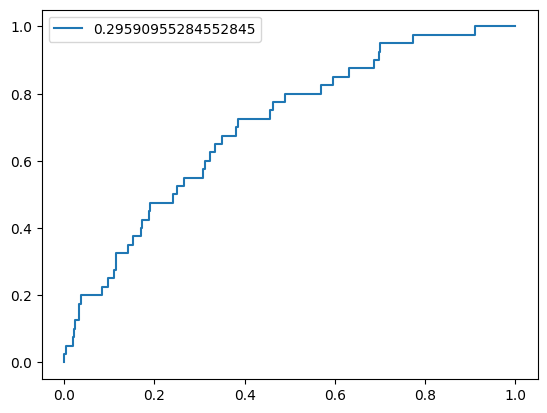

In [131]:
plt.plot(fpr, tpr, label=np.trapz(fpr, tpr))
plt.legend(loc=2)
plt.show()

In [74]:
from src.models.components.embedding.encoder_layer import EncoderLayer
from src.models.components.seq_to_seq.gru_seq_to_seq import GRUSeqToSeq
from src.models.components.pooling.agg_pooling import ConvPooling
from src.models.components.linear_blocks.linear_conv_blocks import MultiTaskLinearBlock, LinearBlock

In [75]:
from lightning import LightningModule
from src.utils.metrics import GINI

In [76]:
from src.models.ch_lit_module import CHLitModule
from IPython.display import display as d

In [166]:
class PretrainedModel(nn.Module):
    def __init__(self, ckpt_path: str):
        super().__init__()
        
        self.net = CHLitModule.load_from_checkpoint(ckpt_path)
        self.net.eval()
        self.net.freeze()

    def forward(self, inputs):
        return self.net(inputs)

In [167]:
trained_model = PretrainedModel("logs/train/runs/2024-05-10_21-40-59/checkpoints/epoch_009.ckpt")

/home/danil/projects/torch_template/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [168]:
d(dict(trained_model.net.named_parameters()))

{'net.layers.0.embeddings.embeddings.0.weight': Parameter containing:
 tensor([[ 0.1163, -0.1310, -0.0592,  0.2793,  0.3741, -0.6908, -0.5971,  0.2201],
         [ 0.0158,  0.4290, -0.4030,  0.0218,  0.0435, -0.1547, -0.0477,  0.1665],
         [-0.0617,  0.2233, -0.1663,  0.4225, -0.3835,  0.7323,  0.3849,  0.2081],
         [ 0.5352,  0.5145,  0.2374, -0.2541,  0.0298,  0.6522,  0.1205,  0.1835],
         [ 0.1011, -0.4466, -0.3656, -0.6524, -0.8061,  0.1351,  0.7707, -0.0579],
         [ 0.0419,  0.1185,  0.3030,  0.0406, -0.0423,  0.7063,  0.4330,  0.3869],
         [-0.0862, -0.5944,  0.1390,  0.1104,  0.3812, -0.3613, -0.2918, -0.1140],
         [-0.5155,  0.3444, -0.0941,  0.0787,  0.1592,  0.0584, -0.1778, -0.1210],
         [ 0.7178, -0.4313,  0.1467, -0.0058, -0.5106, -0.3782, -0.6809, -0.6599],
         [-0.0430,  0.7047,  0.2371, -0.0702, -0.3061,  0.2328,  0.4510, -0.3048],
         [ 0.0031, -1.0576,  0.3733,  0.0736, -0.4612, -0.0251, -0.3969, -0.7177],
         [-0.0506

In [169]:
d(trained_model.net)

CHLitModule(
  (net): SequentialLitModel(
    (layers): Sequential(
      (0): EncoderLayer(
        (dropout): Dropout(p=0.1, inplace=False)
        (embeddings): EmbeddingLayer(
          (embeddings): ModuleList(
            (0-1): 2 x Embedding(20, 8)
            (2): Embedding(7, 8)
            (3): Embedding(6, 8)
            (4): Embedding(1, 8)
            (5): Embedding(4, 8)
            (6): Embedding(14, 8)
            (7-9): 3 x Embedding(20, 8)
            (10-12): 3 x Embedding(2, 8)
            (13-14): 2 x Embedding(7, 8)
            (15): Embedding(6, 8)
            (16): Embedding(5, 8)
            (17): Embedding(18, 8)
            (18): Embedding(17, 8)
          )
        )
        (out_linear_block): Linear(in_features=158, out_features=32, bias=True)
        (num_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): SimpleAttention1d(
        (att_block): Sequential(
          (0): Linear(in_features=32, out_featur

In [170]:
test_sample = next(iter(test_dataloader))
d(GINI()(trained_model.net(test_sample).logits, test_sample.targets))

tensor(54.1870)

In [171]:
preds = [
    trained_model.net(sample).logits.ravel() for i, sample in enumerate(test_dataloader) if i < 5
]

In [172]:
preds = torch.concatenate(preds)

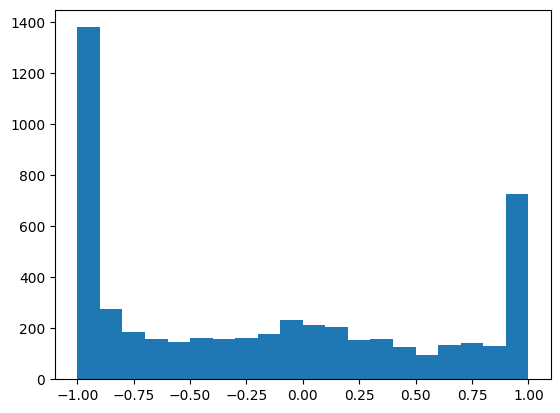

In [173]:
plt.show(plt.hist(preds, bins=20))

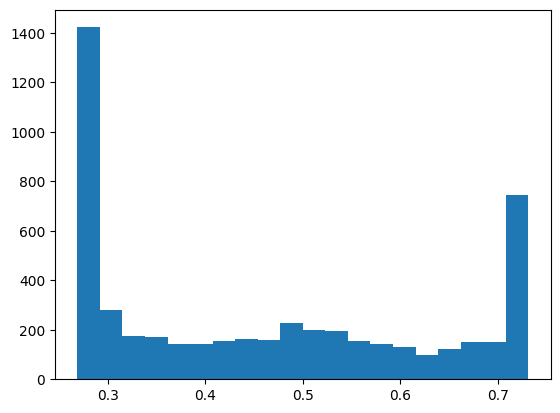

In [174]:
plt.show(plt.hist(torch.sigmoid(preds), bins=20))

In [19]:
import thunder

In [26]:
jit_trained_model = thunder.jit(trained_model.net.net)

In [27]:
preds = jit_trained_model(sample[0])

InterpreterError: Encountered exception AttributeError: module 'dis' has no attribute '_parse_exception_table' while tracing SequentialLitModel(
  (layers): Sequential(
    (0): EncoderLayer(
      (dropout): Dropout(p=0.3, inplace=False)
      (embeddings): EmbeddingLayer(
        (embeddings): ModuleList(
          (0-1): 2 x Embedding(18, 32)
          (2-3): 2 x Embedding(17, 32)
          (4): Embedding(16, 32)
          (5): Embedding(20, 32)
          (6): Embedding(7, 32)
          (7): Embedding(6, 32)
          (8): Embedding(4, 32)
          (9): Embedding(14, 32)
          (10): Embedding(4, 32)
          (11-12): 2 x Embedding(7, 32)
          (13): Embedding(6, 32)
          (14): Embedding(4, 32)
          (15-16): 2 x Embedding(2, 32)
          (17): Embedding(4, 32)
          (18): Embedding(25, 32)
          (19): Embedding(5, 32)
          (20): Embedding(26, 32)
          (21): Embedding(5, 32)
          (22): Embedding(27, 32)
          (23): Embedding(7, 32)
          (24): Embedding(19, 32)
          (25): Embedding(9, 32)
          (26): Embedding(5, 32)
          (27): Embedding(15, 32)
          (28-30): 3 x Embedding(20, 32)
        )
      )
      (out_linear_block): Linear(in_features=992, out_features=32, bias=True)
    )
    (1): GRUSeqToSeq(
      (gru): GRU(32, 32, batch_first=True)
    )
    (2): ConvPooling(
      (pooling_layer): AllPoolings()
      (conv_layer): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    )
    (3): MultiOutputLinearBlock(
      (heads): ModuleList(
        (0): LinearBlock(
          (dropout): Dropout(p=0.0, inplace=False)
          (linear_block): Sequential(
            (0): Sequential(
              (0): Linear(in_features=32, out_features=16, bias=True)
              (1): GELU(approximate='none')
              (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            )
            (1): Sequential(
              (0): Linear(in_features=16, out_features=8, bias=True)
              (1): GELU(approximate='none')
              (2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
            )
          )
          (out_block): Linear(in_features=8, out_features=1, bias=True)
          (cls_layers): Sequential(
            (0): Dropout(p=0.0, inplace=False)
            (1): Sequential(
              (0): Sequential(
                (0): Linear(in_features=32, out_features=16, bias=True)
                (1): GELU(approximate='none')
                (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
              )
              (1): Sequential(
                (0): Linear(in_features=16, out_features=8, bias=True)
                (1): GELU(approximate='none')
                (2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
              )
            )
            (2): Linear(in_features=8, out_features=1, bias=True)
            (3): GELU(approximate='none')
          )
        )
      )
    )
  )
):


In [28]:
trained_model.net.to_onnx("credits_history_lit_model.onnx", sample[0], export_params=True)

RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: ModelInput